In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix

## Generate a keras Dataset

In [2]:
data_fld = '/home/ahoag/ML/mars/attempt1/images_for_cnn'

In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_fld,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)

Found 2024 files belonging to 2 classes.
Using 1620 files for training.
Found 2024 files belonging to 2 classes.
Using 404 files for validation.


## Visualize the data

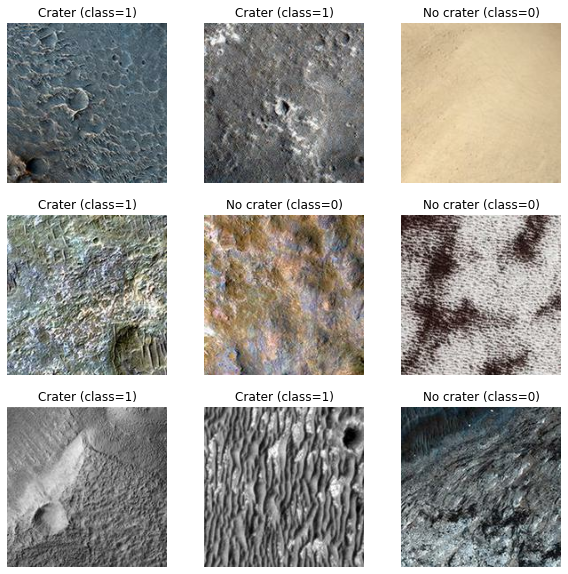

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # Take grabs items at the batch level
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i])
        if label == 0:
            plt_text = "No crater"
        else:
            plt_text = "Crater"
        plt.title(f"{plt_text} (class={label})",fontsize=12)
        plt.axis("off")
plt.savefig('training_set_example.png')

## Using image data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

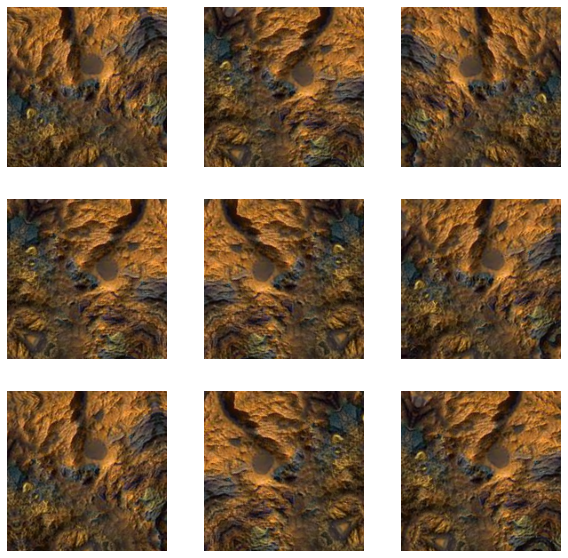

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Configure the dataset for performance

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model
We'll build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using Keras Tuner.

Note that:

- We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
- We include a Dropout layer before the final classification layer.

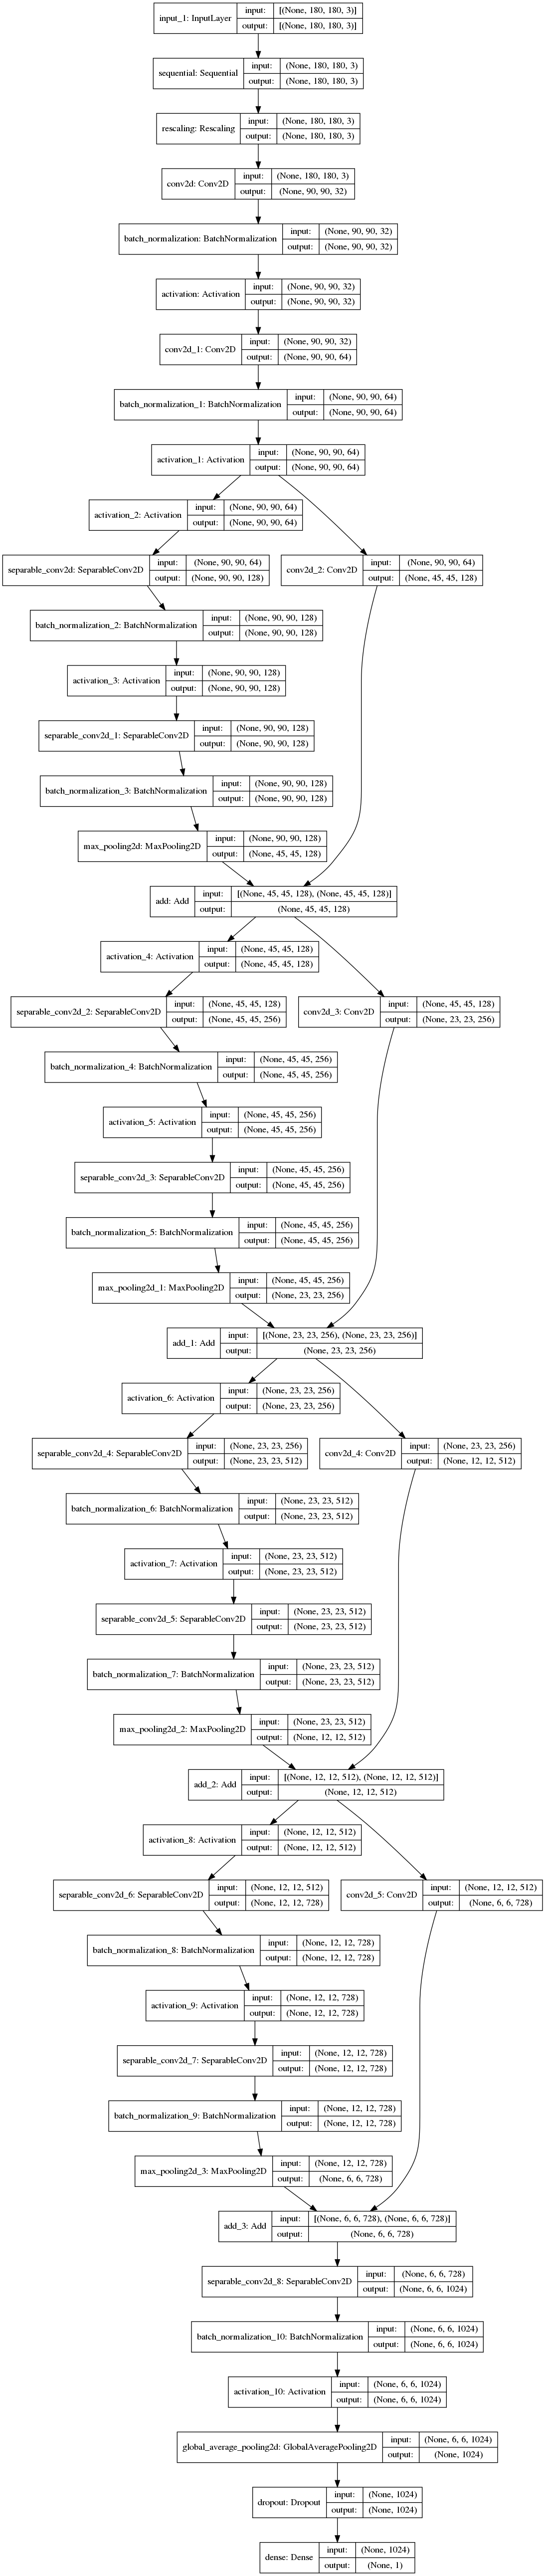

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

## Train the model

In [ ]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint("../attempt1/cnn_saved_epochs_retrain/save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/60
51/51 [==============================] - 76s 1s/step - loss: 0.8893 - accuracy: 0.5061 - val_loss: 0.6923 - val_accuracy: 0.5074
Epoch 2/60
51/51 [==============================] - 72s 1s/step - loss: 0.7451 - accuracy: 0.5381 - val_loss: 0.7128 - val_accuracy: 0.5074
Epoch 3/60
51/51 [==============================] - 73s 1s/step - loss: 0.7268 - accuracy: 0.5321 - val_loss: 0.7598 - val_accuracy: 0.5074
Epoch 4/60
51/51 [==============================] - 73s 1s/step - loss: 0.7031 - accuracy: 0.5642 - val_loss: 0.7237 - val_accuracy: 0.5074
Epoch 5/60
51/51 [==============================] - 72s 1s/step - loss: 0.6897 - accuracy: 0.5867 - val_loss: 0.8445 - val_accuracy: 0.5074
Epoch 6/60
51/51 [==============================] - 73s 1s/step - loss: 0.6925 - accuracy: 0.5555 - val_loss: 0.9260 - val_accuracy: 0.5074
Epoch 7/60
50/51 [============================>.] - ETA: 1s - loss: 0.6844 - accuracy: 0.5688

## Evaluate the model

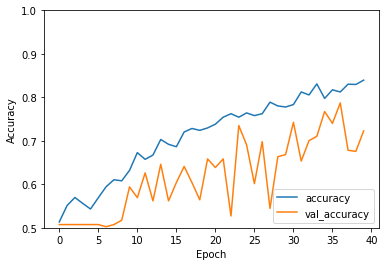

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

We get ~70% accuracy on the validation set after running for 40 epochs. Can see that the accuracy is still increasing after 40 epochs so may want to run for longer. This is encouraging given that we had a limited sample size. The curves are a lot noisier than the cats vs. dogs example which is probably due to the smaller sample size here and noisier images. 

## Run inference on new data
Note that data augmentation and dropout are inactive at inference time.

In [1]:
test_fld = '/home/ahoag/ML/mars/attempt1/test_cnn'

In [42]:
def inference(filename):
    """
    ---PURPOSE---
    
    """
    # Find an image that was not used in training or validation set that I know the answer to. 
    full_filename = os.path.join(test_fld,filename)
    pil_im = Image.open(full_filename)
    img = keras.preprocessing.image.load_img(
        full_filename, target_size=image_size
    )

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    plt.figure(figsize=(4, 4))
    ax = plt.subplot(1,1,1)
    _=plt.imshow(pil_im)
    plt.axis("off")
    predictions = model.predict(img_array)
    score = predictions[0]
    print(
        "P = %.2f that there are craters"
        % (score)
    )
    return 

P = 0.01 that there are craters


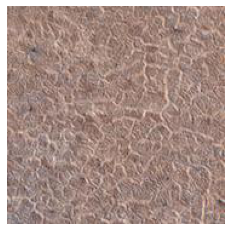

In [43]:
# Find an image that was not used in training or validation set that I know the answer to. 
filename = "PSP_010420_2505_x200-400_y400-600.jpg"
inference(filename)

P = 0.96 that there are craters


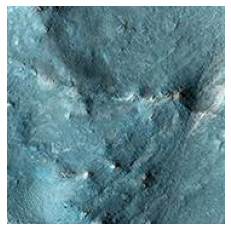

In [44]:
# Find an image that was not used in training or validation set that I know the answer to. 
filename = "ESP_028825_2070_x200-400_y0-200.jpg"
inference(filename)

P = 0.91 that there are craters


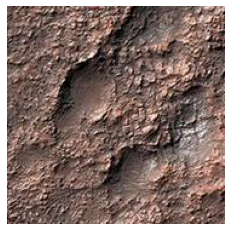

In [45]:
# Find an image that was not used in training or validation set that I know the answer to. 
filename = "ESP_034309_1485_x0-200_y400-600.jpg"
inference(filename)

P = 0.36 that there are craters


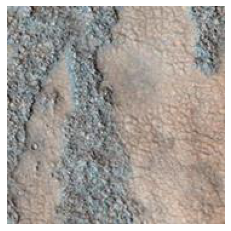

In [47]:
filename="ESP_012725_2015_x0-200_y400-600.jpg"
inference(filename)

These all look good! I think this is working! Maybe coincidence so we will want to make a more thorough test set. 

# Saving the model
The fact that `callbacks` was using during model.fit allowed the model to save out an h5 file after each epoch:
```python
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
```
In test_load_cnn() I showed that I can successfully load the model with:
```python
keras.models.load_model('save_at_40.h5')
```

## Run more epochs
I want to run more epochs leaving off from epoch 40, the last epoch that I ran:

In [49]:
epochs = 10

history2 = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
51/51 [==============================] - 72s 1s/step - loss: 0.3529 - accuracy: 0.8463 - val_loss: 0.4174 - val_accuracy: 0.8243
Epoch 2/10
51/51 [==============================] - 72s 1s/step - loss: 0.3576 - accuracy: 0.8537 - val_loss: 1.0292 - val_accuracy: 0.6559
Epoch 3/10
51/51 [==============================] - 72s 1s/step - loss: 0.3494 - accuracy: 0.8420 - val_loss: 0.6000 - val_accuracy: 0.7574
Epoch 4/10
51/51 [==============================] - 72s 1s/step - loss: 0.3403 - accuracy: 0.8494 - val_loss: 0.4256 - val_accuracy: 0.8193
Epoch 5/10
51/51 [==============================] - 71s 1s/step - loss: 0.3209 - accuracy: 0.8605 - val_loss: 0.4990 - val_accuracy: 0.7822
Epoch 6/10
51/51 [==============================] - 71s 1s/step - loss: 0.3169 - accuracy: 0.8642 - val_loss: 0.5191 - val_accuracy: 0.7574
Epoch 7/10
51/51 [==============================] - 71s 1s/step - loss: 0.3293 - accuracy: 0.8549 - val_loss: 0.4214 - val_accuracy: 0.8144
Epoch 8/10
51/51 [==

It does look like it picked up from where it left off! I can tell by the accuracy of the model being much closer to when it left off (\~0.8) compared to when I started (\~0.5).

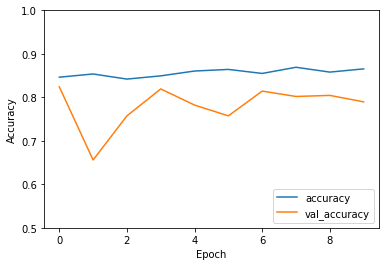

In [50]:
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Leveling off now. Pretty happy with 80% accuracy on validation set! Is there a way to combine this history with the previous? Yes, turns out history.history is just a dictionary:

In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [62]:
all_history = {}
for key in history.history:
    all_history[key] = history.history[key]
    all_history[key].extend(history2.history[key])

{'loss': [0.8290467262268066,
  0.7119218707084656,
  0.7103036642074585,
  0.7376499772071838,
  0.7300420999526978,
  0.7201157808303833,
  0.6980293393135071,
  0.6971441507339478,
  0.6793457269668579,
  0.661236047744751,
  0.6173107028007507,
  0.6253607273101807,
  0.6043964624404907,
  0.5683736801147461,
  0.5902938842773438,
  0.5750182271003723,
  0.5532726645469666,
  0.5444883704185486,
  0.5406911373138428,
  0.5325911045074463,
  0.5219959616661072,
  0.49921271204948425,
  0.4924378991127014,
  0.49957120418548584,
  0.4822819232940674,
  0.4771708548069,
  0.48682495951652527,
  0.4539773166179657,
  0.4542519152164459,
  0.43107807636260986,
  0.4526098072528839,
  0.40583041310310364,
  0.42641210556030273,
  0.40979519486427307,
  0.4215301275253296,
  0.39781856536865234,
  0.3872810900211334,
  0.3762580156326294,
  0.37781664729118347,
  0.360944539308548,
  0.352918416261673,
  0.3576168715953827,
  0.3494299352169037,
  0.34033384919166565,
  0.3208850622177124

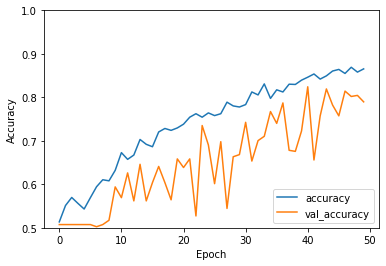

In [63]:
plt.plot(all_history['accuracy'], label='accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [64]:
# It looks like it might still be improving. Try to run for 10 more epochs
epochs = 10
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_round3.h5"),
]
history3 = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
51/51 [==============================] - 73s 1s/step - loss: 0.2936 - accuracy: 0.8809 - val_loss: 0.6124 - val_accuracy: 0.7475
Epoch 2/10
51/51 [==============================] - 73s 1s/step - loss: 0.2978 - accuracy: 0.8759 - val_loss: 0.4131 - val_accuracy: 0.8119
Epoch 3/10
51/51 [==============================] - 73s 1s/step - loss: 0.3048 - accuracy: 0.8704 - val_loss: 0.4645 - val_accuracy: 0.8267
Epoch 4/10
51/51 [==============================] - 73s 1s/step - loss: 0.2790 - accuracy: 0.8870 - val_loss: 0.5951 - val_accuracy: 0.7624
Epoch 5/10
51/51 [==============================] - 73s 1s/step - loss: 0.2774 - accuracy: 0.8809 - val_loss: 0.6574 - val_accuracy: 0.7426
Epoch 6/10
51/51 [==============================] - 73s 1s/step - loss: 0.2790 - accuracy: 0.8778 - val_loss: 0.7649 - val_accuracy: 0.7327
Epoch 7/10
51/51 [==============================] - 72s 1s/step - loss: 0.2785 - accuracy: 0.8827 - val_loss: 0.5674 - val_accuracy: 0.7649
Epoch 8/10
51/51 [==

In [65]:
history3=history2

In [66]:
# View entire history of 60 epochs from 3 runs
# all_history = {}
for key in history.history:
    all_history[key].extend(history3.history[key])
    

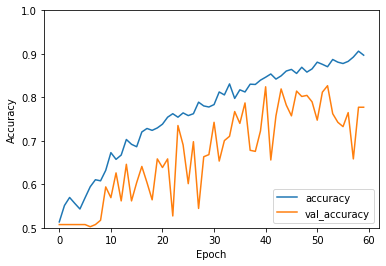

In [67]:
plt.plot(all_history['accuracy'], label='accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

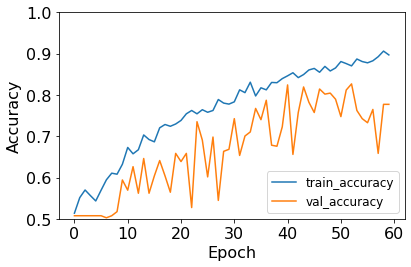

In [328]:
plt.plot(all_history['accuracy'], label='train_accuracy')
plt.plot(all_history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right',fontsize=12)
plt.tight_layout()
plt.savefig('../attempt1/training_attempt1.png')

OK looks like it is overfitting now. Validation accuracy peaked around epoch 52 or 53. Can find the exact peak. 

In [70]:
max_val_acc = max(all_history['val_accuracy'])
all_history['val_accuracy'].index(max_val_acc)+1 

53

In [273]:
print(f"Maximum val_accuracy = {max_val_acc}")

Maximum val_accuracy = 0.8267326951026917


## Evaluate model (at epoch 53) on test set

In [8]:
save_file = '../attempt1/cnn_saved_epochs/save_at_53.h5'
best_model = keras.models.load_model(save_file)

In [6]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_fld,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    class_names=['no_craters','craters']
)


Found 419 files belonging to 2 classes.


i=0,label=1
i=1,label=0
i=2,label=0
i=3,label=1
i=4,label=0
i=5,label=0
i=6,label=1
i=7,label=0
i=8,label=0


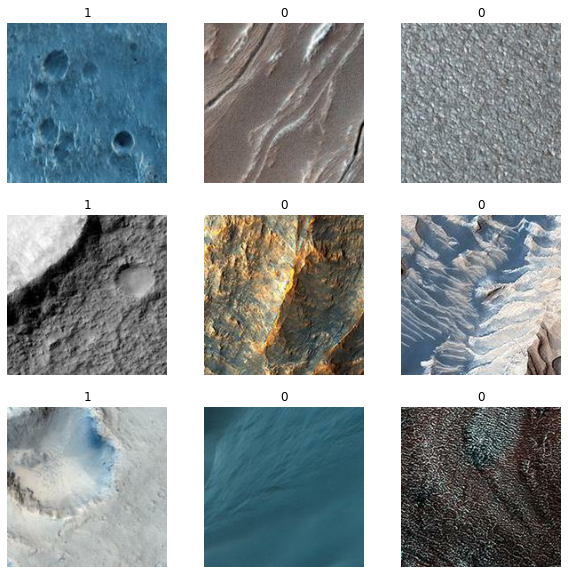

In [7]:
# Take a look at some of these to make sure they were loaded in right
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    for i in range(9):
        print(f"i={i},label={labels[i]}")
        ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [9]:
# Load in test images and labels
result = best_model.evaluate(test_ds)

14/14 [==============================] - 6s 295ms/step - loss: 0.3524 - accuracy: 0.8544


Looks like my test-set accuracy is ~80%. Pretty good. Let's look at confusion matrix

In [10]:
test_predictions = []
test_labels = []
test_probs = []
for x, y in test_ds:
    new_predictions = best_model.predict(x)[:,0]
    test_predictions.extend(list(map(round,new_predictions)))
    test_labels.extend(list(map(round,y.numpy())))
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        test_probs.append(pred_float)
    

In [306]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = 'd'
    fmt_norm = '.2f'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt)+f' ({format(cm_norm[i, j], fmt_norm)})',
                 fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

[[194  25]
 [ 68 132]]


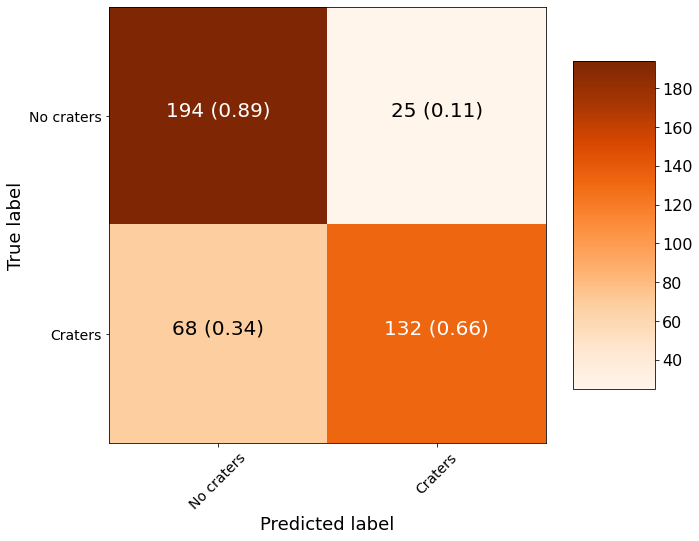

In [308]:
cm = confusion_matrix(test_labels, test_predictions)
plot_confusion_matrix(cm, classes = ['No craters', 'Craters'],
                      title = '',)
plt.tight_layout()
plt.savefig('../attempt1/confusion_matrix_attempt1.png')

So the model is very good at identifying what is NOT a crater. It has a harder time picking up all of the craters. It says there are no craters when there are in fact craters 1/3 of the time. Would be good to look at some of these images to see if there is something about them that could make it difficult. 

In [12]:
false_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_negatives.append(fn_dict)


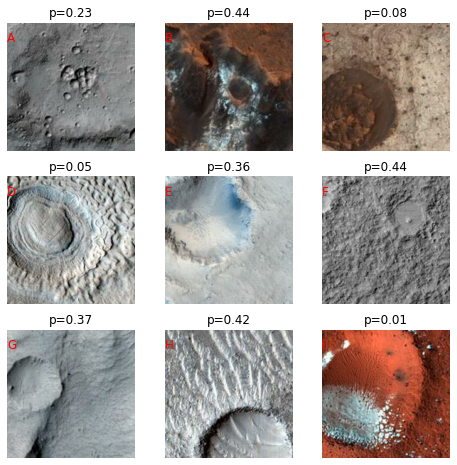

In [15]:
# inspect false negatives
np.random.shuffle(false_negatives)
plt.figure(figsize=(8, 8))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
#         ax.set_title(i)
    plt.imshow(false_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = false_negatives[i]['pred']
    plt.title(f"p={pred_float:.2f}",fontsize=12)
    plt.text(0,0.85,chr(65+i),transform=ax.transAxes,color='r',fontsize='large')
    plt.axis("off")
plt.savefig('../attempt1/false_negatives.png')

In [319]:
plt.text?

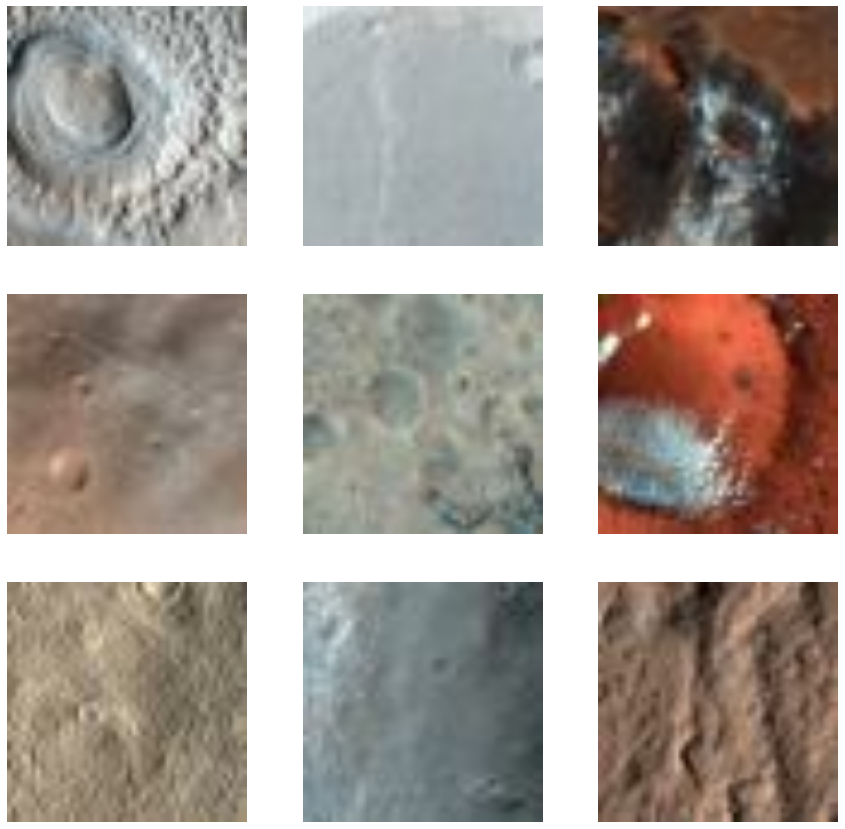

In [260]:
# inspect false negatives
plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3,3, i + 1)
#         ax.set_title(i)
    plt.imshow(false_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = false_negatives[i]['pred']
#     plt.title(f"False Negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

The bottom 3 of these look like hard cases. Really surprised case 4 was such a strong probability of not having a crater

In [215]:
true_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 1 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_positives.append(fn_dict)

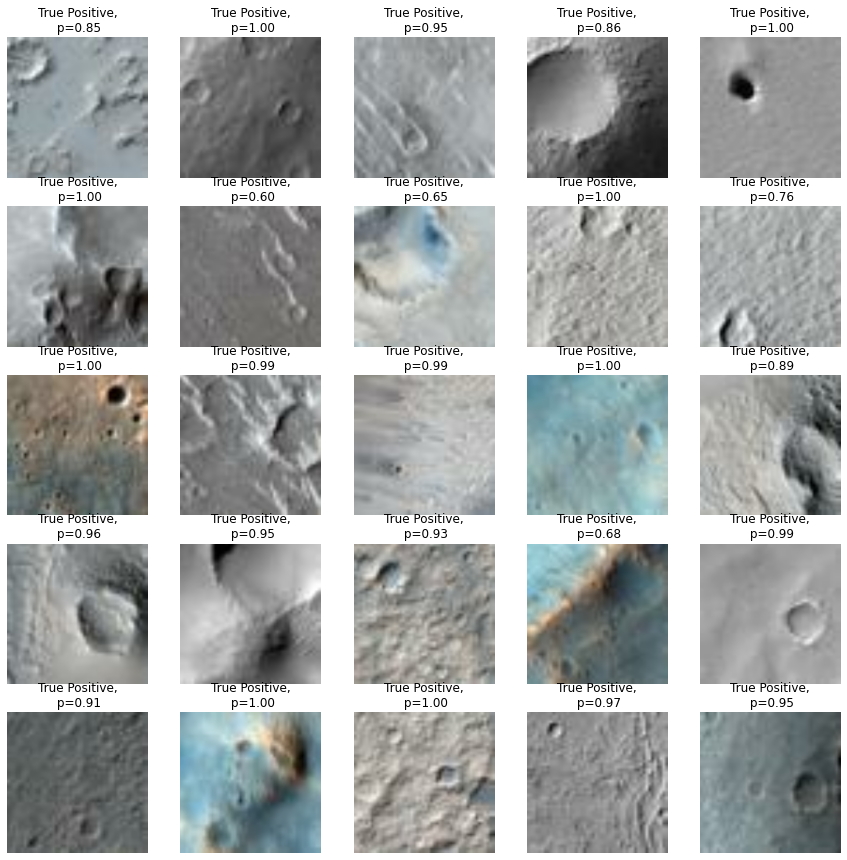

In [248]:
# inspect True positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_positives[i]['image'].numpy().astype("uint8"))
    pred_float = true_positives[i]['pred']
    plt.title(f"True Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

It definitely does seem like the more obvious craters are detected. One thing I am noticing is that in the true positives the backgrounds are much more uniform. In the false negatives (fail to detect a crater that is there) the backgrounds are much more colorful. 

In [221]:
all_probabilities = [] 

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        all_probabilities.append(pred_float)

Text(0, 0.5, 'N')

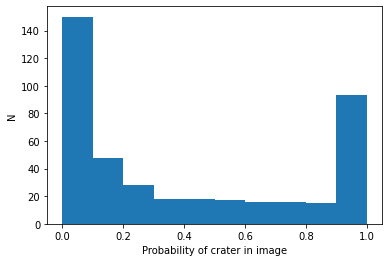

In [223]:
# Plot distribution of actual probabilities
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(all_probabilities)
ax.set_xlabel('Probability of crater in image')
ax.set_ylabel('N')

## ROC - AUC curve

In [234]:
roc_auc_score?

In [242]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """
    Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve.
    ---INPUT---
    predictions:    predicted classes in the test set
    
    """
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [243]:
train_predictions = []
train_labels = []
train_probs = []
for x, y in train_ds:
    new_predictions = best_model.predict(x)[:,0]
    train_predictions.extend(list(map(round,new_predictions)))
    train_labels.extend(list(map(round,y.numpy())))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        train_probs.append(pred_float)
    


Recall Baseline: 1.0 Test: 0.66 Train: 0.92
Precision Baseline: 0.48 Test: 0.84 Train: 0.87
Roc Baseline: 0.5 Test: 0.87 Train: 0.96


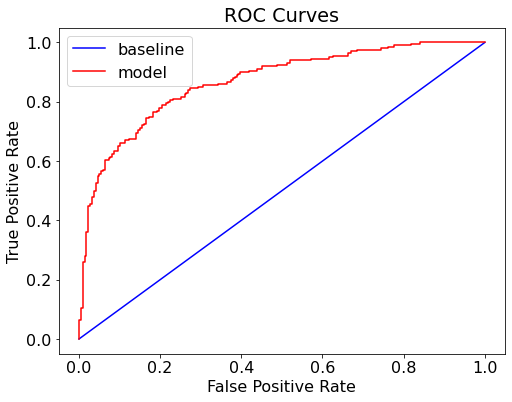

In [244]:
evaluate_model(test_predictions,test_probs,train_predictions, train_probs)

This is about what I got for the titanic survival challenge which isn't bad!

Let's look at some false positives.

In [251]:
false_positives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 1:
            fn_dict = {'image':x[ii],'pred':pred_float}
            false_positives.append(fn_dict)

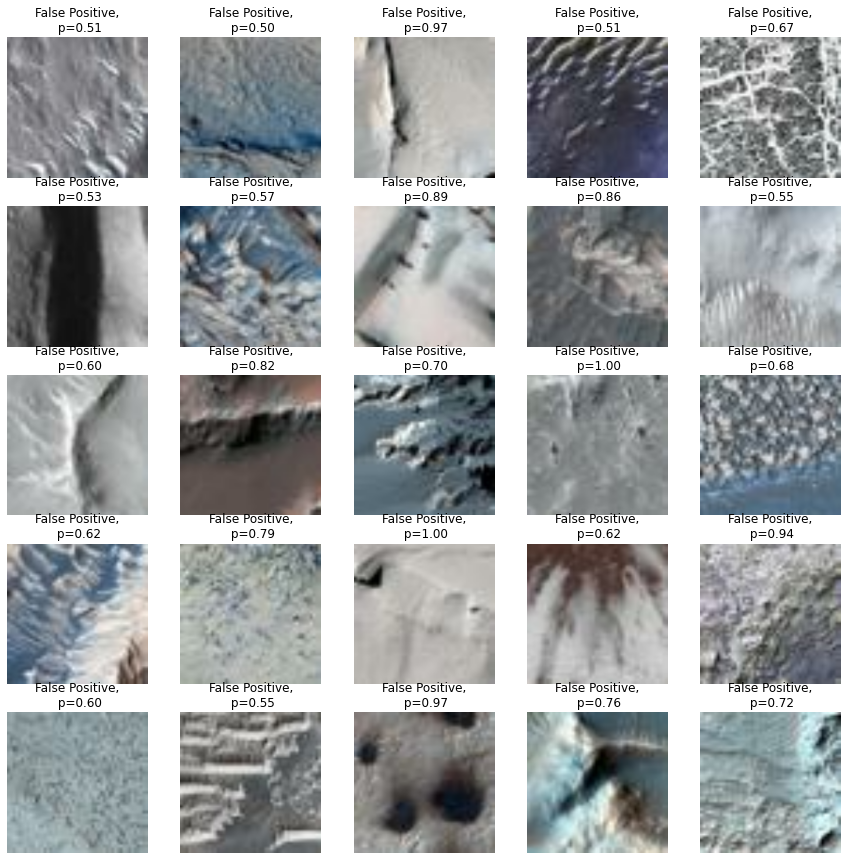

In [252]:
# inspect false positives
plt.figure(figsize=(15, 15))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(false_positives[i]['image'].numpy().astype("uint8"))
    pred_float = false_positives[i]['pred']
    plt.title(f"False Positive,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

These have a similar background color to the true positives, so it might be using background color here. Another reason to use grayscale instead of color images. 

In [253]:
true_negatives = [] # will be a list of dictionaries with 
# each dictionary being: {'image':numpy array of the image,'pred':floating point prediction between 0 and 1}

for x, y in test_ds: # loop over batches
    new_predictions = best_model.predict(x)[:,0]
    new_labels = list(map(round,y.numpy()))
    for ii in range(len(new_predictions)):
        pred_float = new_predictions[ii]
        pred_binary = round(pred_float)
        truth = new_labels[ii]
        if truth == 0 and pred_binary == 0:
            fn_dict = {'image':x[ii],'pred':pred_float}
            true_negatives.append(fn_dict)

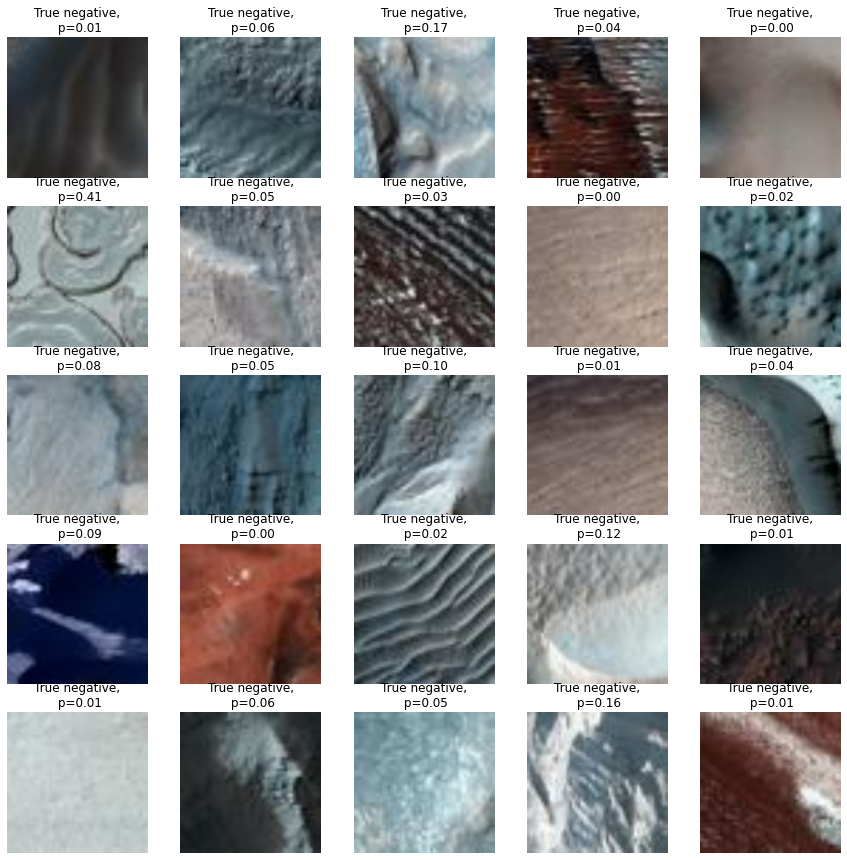

In [256]:
# inspect true negative
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
#         ax.set_title(i)
    plt.imshow(true_negatives[i]['image'].numpy().astype("uint8"))
    pred_float = true_negatives[i]['pred']
    plt.title(f"True negative,\n p={pred_float:.2f}",fontsize=12)
    plt.axis("off")

In [257]:
# Save best model
best_model.save('../cnn_saved_epochs/best_model_epoch53.h5')

## Things to do
- Run the model on the rest of the dataset.
- A bigger training/validation set. It's pretty amazing it is doing as well as it is given the limited size of the training set I used.
- Try using grayscale images instead of color. Color might be throwing off the model. 
- Figure out how to do cross validation with this kind of model
- Keras tuner
- Try different CNN architectures
- Try use_multiprocessing=True in model.fit() to see if we get improvement
- Try different image sizes to see if that helps/hurts training
- Purify training/val set to only include obvious craters
- Learn how to look at the intermediate filters in my model

## Done
- Make a test set and evaluate the model on that -- Take a look at confusion matrix/ ROC-AUC curve
